**验证GPU及PyTorch、TensorFlow版本**

In [1]:
import tensorflow as tf
import torch

# 检查 TensorFlow
print("\n=== TensorFlow 信息 ===")
print(f"版本: {tf.__version__}")
print(f"GPU 可用性: {'是' if tf.config.list_physical_devices('GPU') else '否'}")

# 检查 PyTorch
print("\n=== PyTorch 信息 ===")
print(f"版本: {torch.__version__}")
print(f"CUDA 可用性: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"当前 GPU 设备: {torch.cuda.get_device_name(0)}")

2025-04-05 21:05:46.336881: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-05 21:05:47.005013: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-05 21:05:48.216097: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT



=== TensorFlow 信息 ===
版本: 2.16.1
GPU 可用性: 是

=== PyTorch 信息 ===
版本: 2.3.1+cu121


2025-04-05 21:05:53.018498: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


CUDA 可用性: True
当前 GPU 设备: NVIDIA A10


2025-04-05 21:05:53.028741: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-05 21:05:53.028970: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


**导入库**

In [1]:
import pandas as pd
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
import numpy as np

**验证图片名称对应，清除无效项**

In [4]:
def clean_dataset(csv_path, img_dir):
    df = pd.read_csv(csv_path)
    
    # 过滤无效图片路径
    valid_paths = []
    for idx, row in df.iterrows():
        img_path = os.path.join(img_dir, row['path'])
        if os.path.exists(img_path):
            try:
                Image.open(img_path).verify()  # 验证图片完整性
                valid_paths.append(True)
            except:
                valid_paths.append(False)
        else:
            valid_paths.append(False)
    
    df = df[valid_paths]
    print(f"清洗后有效数据量: {len(df)}")
    return df

# 参数配置
csv_path = "./data/picture.csv"
img_dir = "../pic"
df_clean = clean_dataset(csv_path, img_dir)

清洗后有效数据量: 16521


**检验数据集可用性**

In [5]:
import pandas as pd

# 定义列数据类型
dtype_dict = {
    '区位': int,
    '餐饮': int,
    '房间设施': int,
    '娱乐设施': int,
    '店内设施': int,
    '服务': int,
    '风格化': int,
    '其他': int,
    '主观感受': int
}

# 读取CSV并指定类型
df = pd.read_csv("./data/picture.csv", index_col=0, dtype=dtype_dict)

# 检查数据类型是否正确
print(df.dtypes)

theme_cols = ['区位','餐饮','房间设施','娱乐设施','店内设施','服务','风格化','其他']

# 检查是否有无法转换的异常值
for col in theme_cols + ['主观感受']:
    invalid = pd.to_numeric(df[col], errors='coerce').isna()
    if invalid.any():
        print(f"列 '{col}' 中存在无效值，行索引: {df[invalid].index.tolist()}")
        # 修复或删除这些行
        df = df[~invalid]
        
# 精准清洗（仅处理数值列）
theme_cols = ['区位','餐饮','房间设施','娱乐设施','店内设施','服务','风格化','其他']
sentiment_col = '主观感受'

# 1. 仅转换需要的列
df_clean = df.copy()
df_clean[theme_cols] = df[theme_cols].apply(pd.to_numeric, errors='coerce')
df_clean[sentiment_col] = pd.to_numeric(df[sentiment_col], errors='coerce')

# 2. 仅删除关键列中的无效行
df_clean = df_clean.dropna(subset=theme_cols + [sentiment_col])

# 3. 保留非数值列（如path）
print("有效样本数:", len(df_clean))  # 应显示16521

# 在调用 train_test_split 前添加验证
print("划分前的数据形状:", df_clean.shape)  # 应为 (16521, 10)
print("是否存在NaN:", df_clean.isnull().sum().sum())  # 应为 0

path    object
区位       int64
餐饮       int64
房间设施     int64
娱乐设施     int64
店内设施     int64
服务       int64
风格化      int64
其他       int64
主观感受     int64
dtype: object
有效样本数: 16521
划分前的数据形状: (16521, 10)
是否存在NaN: 0


**数据集划分**

In [6]:
class HotelDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform or transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['path'])
        
        # 加载图像（带错误处理）
        try:
            image = Image.open(img_path).convert('RGB')
        except:
            image = Image.new('RGB', (224, 224), (0, 0, 0))  # 创建黑色占位图
        
        image = self.transform(image)
        
        # 显式转换为浮点张量
        theme_labels = torch.tensor(
            row[theme_cols].values.astype(np.float32), 
            dtype=torch.float32
        )
        
        # 情感标签处理
        sentiment_label = torch.tensor(
            int(row['主观感受']) + 1,  # 强制转换为整数
            dtype=torch.long
        )
        
        return image, {
            'themes': theme_labels,
            'sentiment': sentiment_label
        }

# 划分数据集
from sklearn.model_selection import train_test_split

# 确保使用清洗后的数据
train_df, val_df = train_test_split(
    df_clean, 
    test_size=0.2,
    random_state=42  # 添加随机种子保证可复现性
)
print("训练集样本数:", len(train_df))  # 应约 13216
print("验证集样本数:", len(val_df))    # 应约 3305
train_dataset = HotelDataset(train_df, img_dir)
val_dataset = HotelDataset(val_df, img_dir)

训练集样本数: 13216
验证集样本数: 3305


**注意力机制+ResNet-101**

In [3]:
from torchvision.models.resnet import ResNet101_Weights
import torch
from torch import nn
import torchvision.models as models

class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction_ratio),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction_ratio, in_channels),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x).flatten(1))  
        max_out = self.fc(self.max_pool(x).flatten(1))
        return x * (avg_out + max_out).unsqueeze(-1).unsqueeze(-1)


class ResNet101Att(nn.Module):
    def __init__(self):
        super().__init__()
        base_model = models.resnet101(weights=ResNet101_Weights.IMAGENET1K_V1)
        
        # 完整的特征提取部分
        self.features = nn.Sequential(
            base_model.conv1,           # [batch, 64, 112, 112]
            base_model.bn1,
            base_model.relu,
            base_model.maxpool,         # [batch, 64, 56, 56]
            base_model.layer1,          # [batch, 256, 56, 56]
            ChannelAttention(256),      # 插入通道注意力
            base_model.layer2,          # [batch, 512, 28, 28]
            ChannelAttention(512),      # 插入通道注意力
            base_model.layer3,          # [batch, 1024, 14, 14]
            base_model.layer4,          # [batch, 2048, 7, 7]
            ChannelAttention(2048)      # 插入通道注意力
        )
        
        # 多任务输出头
        self.avgpool = base_model.avgpool  # [batch, 2048, 1, 1]
        
        # 主题分类头（8个二分类）
        self.theme_head = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 8),
            nn.Sigmoid()
        )
        
        # 情感分类头（三分类）
        self.sentiment_head = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 3)
        )

        # 冻结参数策略
        for param in base_model.parameters():
            param.requires_grad = False
        for param in base_model.layer3.parameters():
            param.requires_grad = True
        for param in base_model.layer4.parameters():
            param.requires_grad = True

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        
        return {
            'themes': self.theme_head(x),
            'sentiment': self.sentiment_head(x)
        }

**训练过程**

In [10]:
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import os

# 训练配置
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet101Att().to(device)
criterion = {
    'themes': nn.BCELoss(),          # 二分类用BCE
    'sentiment': nn.CrossEntropyLoss() # 三分类用交叉熵
}
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# 创建保存目录
save_dir = "saved_models"
os.makedirs(save_dir, exist_ok=True)

# 初始化最佳准确率记录
best_val_acc = 0.0

# 数据加载
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# 训练循环
for epoch in range(10):
    model.train()
    
    # 训练进度条
    train_loop = tqdm(
        iterable=train_loader,
        desc=f"Epoch {epoch+1}/10 [Train]",
        total=len(train_loader),
        leave=True,
        dynamic_ncols=True
    )
    
    # 修改训练循环中的损失计算部分
    for inputs, labels in train_loop:
        inputs = inputs.to(device)
        theme_labels = labels['themes'].to(device)      # 转移到GPU
        sentiment_labels = labels['sentiment'].to(device)  # 转移到GPU

        optimizer.zero_grad()
        outputs = model(inputs)

        # 修正后的损失计算（使用已转移到GPU的labels）
        loss = 0.7 * criterion['themes'](outputs['themes'], theme_labels) \
               + 0.3 * criterion['sentiment'](outputs['sentiment'], sentiment_labels) 
    
    loss.backward()
    optimizer.step()
    train_loop.set_postfix(loss=f"{loss.item():.4f}")

    # 验证
    model.eval()
    total_theme_acc = 0.0
    total_sentiment_acc = 0.0
    total_samples = 0
    
    val_loop = tqdm(
        val_loader,
        desc=f"Epoch {epoch+1}/10 [Val]",
        total=len(val_loader),
        leave=False
    )
    
    with torch.no_grad():
        for inputs, labels in val_loop:
            inputs = inputs.to(device)
            true_themes = labels['themes'].to(device)
            true_sentiment = labels['sentiment'].to(device)
            
            outputs = model(inputs)
            
            # 主题准确率
            pred_themes = (outputs['themes'] > 0.5).float()
            theme_acc = (pred_themes == true_themes).float().mean()
            
            # 情感准确率
            pred_sentiment = torch.argmax(outputs['sentiment'], dim=1)
            sentiment_acc = (pred_sentiment == true_sentiment).float().mean()
            
            total_theme_acc += theme_acc.item() * inputs.size(0)
            total_sentiment_acc += sentiment_acc.item() * inputs.size(0)
            total_samples += inputs.size(0)
    
    avg_theme_acc = 100 * total_theme_acc / total_samples
    avg_sentiment_acc = 100 * total_sentiment_acc / total_samples
    print(f"Epoch {epoch+1}, Theme Acc: {avg_theme_acc:.2f}%, Sentiment Acc: {avg_sentiment_acc:.2f}%")

    # ======== 修正模型保存逻辑 ========
    # 策略1：保存完整epoch模型
    epoch_filename = f"{save_dir}/epoch_{epoch+1}_theme_{avg_theme_acc:.2f}_sentiment_{avg_sentiment_acc:.2f}.pth"
    torch.save({
        'epoch': epoch+1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'theme_acc': avg_theme_acc,
        'sentiment_acc': avg_sentiment_acc,
    }, epoch_filename)
    print(f"Saved epoch model: {epoch_filename}")

    # 策略2：保存最佳情感模型
    if avg_sentiment_acc > best_val_acc:
        best_val_acc = avg_sentiment_acc
        best_filename = f"{save_dir}/best_sentiment_acc_{best_val_acc:.2f}.pth"
        torch.save({
            'epoch': epoch+1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'sentiment_acc': best_val_acc,
        }, best_filename)
        print(f"New best sentiment model saved: {best_filename}")

Epoch 1/10 [Train]:   0%|          | 0/413 [00:00<?, ?it/s]

Epoch 1/10 [Val]:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 1, Theme Acc: 89.22%, Sentiment Acc: 46.99%
Saved epoch model: saved_models/epoch_1_theme_89.22_sentiment_46.99.pth
New best sentiment model saved: saved_models/best_sentiment_acc_46.99.pth


Epoch 2/10 [Train]:   0%|          | 0/413 [00:00<?, ?it/s]

Epoch 2/10 [Val]:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 2, Theme Acc: 90.95%, Sentiment Acc: 48.56%
Saved epoch model: saved_models/epoch_2_theme_90.95_sentiment_48.56.pth
New best sentiment model saved: saved_models/best_sentiment_acc_48.56.pth


Epoch 3/10 [Train]:   0%|          | 0/413 [00:00<?, ?it/s]

Epoch 3/10 [Val]:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 3, Theme Acc: 90.98%, Sentiment Acc: 47.05%
Saved epoch model: saved_models/epoch_3_theme_90.98_sentiment_47.05.pth


Epoch 4/10 [Train]:   0%|          | 0/413 [00:00<?, ?it/s]

Epoch 4/10 [Val]:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 4, Theme Acc: 90.99%, Sentiment Acc: 47.11%
Saved epoch model: saved_models/epoch_4_theme_90.99_sentiment_47.11.pth


Epoch 5/10 [Train]:   0%|          | 0/413 [00:00<?, ?it/s]

Epoch 5/10 [Val]:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 5, Theme Acc: 90.99%, Sentiment Acc: 48.87%
Saved epoch model: saved_models/epoch_5_theme_90.99_sentiment_48.87.pth
New best sentiment model saved: saved_models/best_sentiment_acc_48.87.pth


Epoch 6/10 [Train]:   0%|          | 0/413 [00:00<?, ?it/s]

Epoch 6/10 [Val]:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 6, Theme Acc: 90.99%, Sentiment Acc: 47.84%
Saved epoch model: saved_models/epoch_6_theme_90.99_sentiment_47.84.pth


Epoch 7/10 [Train]:   0%|          | 0/413 [00:00<?, ?it/s]

Epoch 7/10 [Val]:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 7, Theme Acc: 90.99%, Sentiment Acc: 49.11%
Saved epoch model: saved_models/epoch_7_theme_90.99_sentiment_49.11.pth
New best sentiment model saved: saved_models/best_sentiment_acc_49.11.pth


Epoch 8/10 [Train]:   0%|          | 0/413 [00:00<?, ?it/s]

Epoch 8/10 [Val]:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 8, Theme Acc: 90.99%, Sentiment Acc: 50.41%
Saved epoch model: saved_models/epoch_8_theme_90.99_sentiment_50.41.pth
New best sentiment model saved: saved_models/best_sentiment_acc_50.41.pth


Epoch 9/10 [Train]:   0%|          | 0/413 [00:00<?, ?it/s]

Epoch 9/10 [Val]:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 9, Theme Acc: 90.99%, Sentiment Acc: 50.35%
Saved epoch model: saved_models/epoch_9_theme_90.99_sentiment_50.35.pth


Epoch 10/10 [Train]:   0%|          | 0/413 [00:00<?, ?it/s]

Epoch 10/10 [Val]:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 10, Theme Acc: 90.99%, Sentiment Acc: 51.26%
Saved epoch model: saved_models/epoch_10_theme_90.99_sentiment_51.26.pth
New best sentiment model saved: saved_models/best_sentiment_acc_51.26.pth


**实例使用**

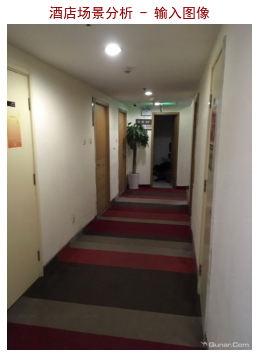


预测结果:
主题概率分布:
区位      : 11.7%
餐饮      : 11.2%
房间设施    : 19.3%
娱乐设施    : 11.3%
店内设施    : 12.6%
服务      : 11.2%
风格化     : 11.5%
其他      : 11.1%

主要相关主题: 房间设施

情感倾向:
预测类别: 中性 (0)
概率分布:
消极    : 15.0%
中性    : 49.7%
积极    : 35.4%


In [6]:
import matplotlib.pyplot as plt  

def load_model(checkpoint_path, device='cuda'):
    """加载训练好的模型"""
    # 创建模型实例
    model = ResNet101Att()
    
    # 加载权重
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=device)
        if 'model_state_dict' in checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'])
        else:  # 直接加载state_dict
            model.load_state_dict(checkpoint)
    else:
        raise FileNotFoundError(f"模型文件 {checkpoint_path} 不存在")
    
    model = model.to(device)
    model.eval()
    return model

def preprocess_image(image_path):
    """图像预处理"""
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0)

# 4. 预测函数
def predict(image_path, model, device='cuda'):
    # 预处理
    input_tensor = preprocess_image(image_path).to(device)
    
    # 推理
    with torch.no_grad():
        outputs = model(input_tensor)
    
    # 后处理
    theme_probs = torch.softmax(outputs['themes'], dim=1).cpu().numpy()[0]
    theme_names = ['区位','餐饮','房间设施','娱乐设施','店内设施','服务','风格化','其他']
    main_theme = theme_names[np.argmax(theme_probs)]
    
    sentiment_probs = outputs['sentiment'].softmax(dim=1).cpu().numpy()[0]
    sentiment_labels = {
        0: '消极 (-1)',
        1: '中性 (0)',
        2: '积极 (1)'
    }
    sentiment_id = np.argmax(sentiment_probs)
    
    return {
        'theme_probs': dict(zip(theme_names, theme_probs.tolist())),
        'main_theme': main_theme,
        'sentiment': sentiment_labels[sentiment_id],
        'sentiment_probs': {
            '消极': sentiment_probs[0],
            '中性': sentiment_probs[1],
            '积极': sentiment_probs[2]
        }
    }

# 5. 使用示例
if __name__ == "__main__":
    # 配置参数
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model_path = "saved_models/best_sentiment_acc_51.26.pth"
    test_image = "../pic/1016906_4.jpg"
    try:
        # 加载并显示原始图像
        img = Image.open(test_image)
        
        plt.figure(figsize=(10, 6))  # 创建画布
        plt.imshow(img)
        plt.title("酒店场景分析 - 输入图像", 
                 fontsize=14, 
                 fontproperties='SimHei',  # 中文字体
                 color='darkred')         # 标题颜色
        plt.axis('off')  # 隐藏坐标轴
        plt.show()       # 显示图像
        
    except Exception as e:
        print(f"\n⚠️ 图片加载失败: {str(e)}")
        print(f"请检查图片路径: {os.path.abspath(test_image)}")
    
    # 加载模型
    model = load_model(model_path, device)
    
    # 执行预测
    results = predict(test_image, model, device)
    
    # 打印结果
    print("\n预测结果:")
    print("="*40)
    print("主题概率分布:")
    for name, prob in results['theme_probs'].items():
        print(f"{name.ljust(8)}: {prob*100:.1f}%")
    
    print(f"\n主要相关主题: {results['main_theme']}")
    
    print("\n情感倾向:")
    print(f"预测类别: {results['sentiment']}")
    print("概率分布:")
    for k, v in results['sentiment_probs'].items():
        print(f"{k.ljust(6)}: {v*100:.1f}%")